### Цели и задачи проекта
 Необходимо отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике. 
 Провести разведывательный анализ данных и составить отчёт по его результатам
 Определиться с параметрами будущей модели, 
 

In [1649]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations

In [1650]:
# load data from a local csv file
stud = pd.read_csv('stud_math.csv')  # original

# Map the lowering function to all column names
stud.columns = map(str.lower, stud.columns)

# make a copy of the original dataframe
df = stud.copy()  # copy of stud dataframe

max_rows = df.shape[0]
max_columns = 50
pd.set_option('display.max_rows', max_rows)  # показывать больше строк
pd.set_option('display.max_columns', max_columns)  # показывать больше колонок

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/dmitriy.stor/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1650-241631177ad1>", line 2, in <module>
    stud = pd.read_csv('stud_math.csv')  # original
  File "/Users/dmitriy.stor/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 676, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/Users/dmitriy.stor/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 448, in _read
    parser = TextFileReader(fp_or_buf, **kwds)
  File "/Users/dmitriy.stor/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 880, in __init__
    self._make_engine(self.engine)
  File "/Users/dmitriy.stor/opt/anaconda3/lib/python3.7/site-packages/pandas/io/parsers.py", line 1114, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/Users/dmitriy

OSError: Initializing from file failed

###### Preprocessing

In [1590]:
def get_hist(col):
    plt.figure(figsize=(8, 4))
    bins = col.nunique()
    range = (col.min(), col.max())
    perc25 = col.quantile(0.25)
    perc75 = col.quantile(0.75)
    IQR = perc75 - perc25
    print('25th percentile: {},'.format(perc25),
          '75th percentile: {},'.format(perc75),
          "IQR: {}, ".format(IQR),
          "\noutliers cutoff: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    col.hist(alpha=0.5, label=col.name, bins=bins, range=range)
    col.loc[col.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)
            ].hist(label=col.name+'_IQR', bins=bins, range=range)
    plt.legend()
    plt.show()


def get_pairplot(col_names):
    sns.pairplot(data=df,
                 y_vars=['score'], x_vars=col_names, kind='reg')
    plt.show()


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column):  # student test
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if stats.ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                           df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Bonferroni correction
            print('significant differences: ', column)
            break


def group_cols(col1, col2):
    return df.groupby(col1)[col2].value_counts(dropna=False)


def group_with_score(name):
    return df.groupby(name).score.agg(['mean', 'median', 'count']).sort_values('median')

### 1. Understanding data

In [1591]:
# display(df.head())
# display(df.tail())
print("shape: ", df.shape)
# display(df.info())

shape:  (395, 30)


In [1592]:
print("rows with missing values: ", df.isnull().any(axis=1).sum())

rows with missing values:  298


In [1593]:
# percentage of null values in columns
(df.isnull().sum()/len(df)).sort_values(ascending=False)

pstatus                0.113924
paid                   0.101266
famsup                 0.098734
fjob                   0.091139
internet               0.086076
romantic               0.078481
guardian               0.078481
traveltime             0.070886
famsize                0.068354
famrel                 0.068354
fedu                   0.060759
failures               0.055696
higher                 0.050633
mjob                   0.048101
reason                 0.043038
address                0.043038
nursery                0.040506
health                 0.037975
activities             0.035443
absences               0.030380
freetime               0.027848
schoolsup              0.022785
goout                  0.020253
studytime              0.017722
studytime, granular    0.017722
score                  0.015190
medu                   0.007595
age                    0.000000
sex                    0.000000
school                 0.000000
dtype: float64

### 2. Data cleansing

In [1594]:
# check duplicates and empty rows
df.drop_duplicates(inplace=True)
df.dropna(axis=0, how='all', inplace=True)
df.shape

(395, 30)

In [1595]:
# get numerical & categorical column names
cols_num = df.loc[:].select_dtypes(include=['int64', 'float64']).columns
cols_cat = df.loc[:].select_dtypes(include='O').columns
print('numerical columns: ', cols_num.size)
print('categorical columns: ', cols_cat.size)

numerical columns:  13
categorical columns:  17


###### 2.1. numerical data

In [1596]:
# unique values
for col in cols_num:
    print(df[col].name, df[col].dropna().sort_values().unique())

age [15 16 17 18 19 20 21 22]
medu [0. 1. 2. 3. 4.]
fedu [ 0.  1.  2.  3.  4. 40.]
traveltime [1. 2. 3. 4.]
studytime [1. 2. 3. 4.]
failures [0. 1. 2. 3.]
studytime, granular [-12.  -9.  -6.  -3.]
famrel [-1.  1.  2.  3.  4.  5.]
freetime [1. 2. 3. 4. 5.]
goout [1. 2. 3. 4. 5.]
health [1. 2. 3. 4. 5.]
absences [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  28.
  30.  38.  40.  54.  56.  75. 212. 385.]
score [  0.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.  80.
  85.  90.  95. 100.]


In [1597]:
# Correct typos
df.fedu.replace(40, 4, inplace=True)
df.famrel.replace(-1, 1, inplace=True)

25th percentile: 16.0, 75th percentile: 18.0, IQR: 2.0,  
outliers cutoff: [13.0, 21.0].


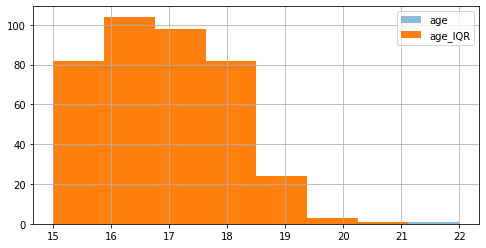

In [1598]:
get_hist(df.age)

In [1599]:
# replace outliers values
df.loc[df.age > 20, 'age'] = 20

25th percentile: 0.0, 75th percentile: 8.0, IQR: 8.0,  
outliers cutoff: [-12.0, 20.0].


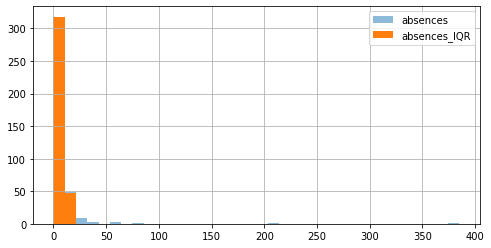

In [1600]:
get_hist(df.absences)

In [1601]:
# replace outliers values
df.loc[df.absences > 20, 'absences'] = 20

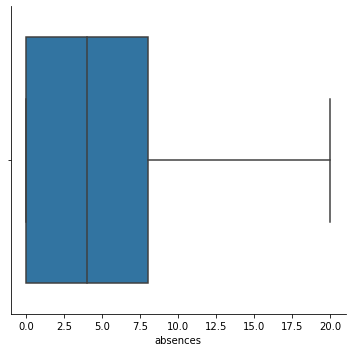

In [1602]:
# check outliers
sns.catplot(x='absences', kind='box', data=df)  # .fig.set_figheight(2)
plt.show()

25th percentile: 40.0, 75th percentile: 70.0, IQR: 30.0,  
outliers cutoff: [-5.0, 115.0].


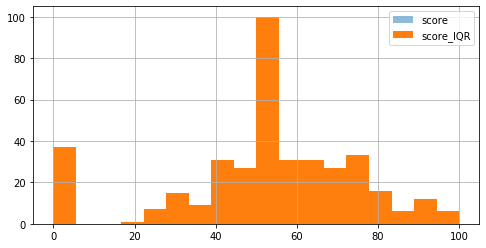

In [1603]:
get_hist(df.score)

In [1604]:
# remove rows with missing values in 'score'
df.drop(df.loc[df.score.isnull()].index, inplace=True)
df.shape

(389, 30)

###### 2.2. categorical data

In [1605]:
# number of unique values
print(dict(df[cols_cat].nunique().sort_values()))

{'school': 2, 'higher': 2, 'nursery': 2, 'activities': 2, 'paid': 2, 'famsup': 2, 'schoolsup': 2, 'internet': 2, 'romantic': 2, 'pstatus': 2, 'famsize': 2, 'address': 2, 'sex': 2, 'guardian': 3, 'reason': 4, 'fjob': 5, 'mjob': 5}


In [1606]:
# unique values
for col in cols_cat:
    print(df[col].name, df[col].dropna().sort_values().unique())

school ['GP' 'MS']
sex ['F' 'M']
address ['R' 'U']
famsize ['GT3' 'LE3']
pstatus ['A' 'T']
mjob ['at_home' 'health' 'other' 'services' 'teacher']
fjob ['at_home' 'health' 'other' 'services' 'teacher']
reason ['course' 'home' 'other' 'reputation']
guardian ['father' 'mother' 'other']
schoolsup ['no' 'yes']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['no' 'yes']
higher ['no' 'yes']
internet ['no' 'yes']
romantic ['no' 'yes']


###### 2.3. Fill in columns

In [1607]:
group_cols('pstatus', 'famsize')

pstatus  famsize
A        GT3         20
         LE3         13
         NaN          3
T        GT3        207
         LE3         81
         NaN         20
Name: famsize, dtype: int64

In [1608]:
# fill in pstatus for family size > 3
df.loc[((df['pstatus'].isnull()) & (df['famsize'] == 'GT3')), 'pstatus'] = 'T'

In [1609]:
group_cols('traveltime', 'address')

traveltime  address
1.0         U          198
            R           34
            NaN          7
2.0         U           63
            R           26
            NaN          5
3.0         R           12
            U            9
4.0         R            4
            U            3
Name: address, dtype: int64

In [1611]:
# fill in address 'U' if travel time to school < 30 min
df.loc[((df['address'].isnull()) & (df['traveltime'] <= 2)), 'address'] = 'U'

In [1516]:
group_cols('age', 'romantic')

age  romantic
15   no          53
     yes         18
     NaN         11
16   no          69
     yes         27
     NaN          7
17   no          58
     yes         34
     NaN          6
18   no          42
     yes         32
     NaN          6
19   no          10
     yes         10
     NaN          1
20   no           3
     yes          2
Name: romantic, dtype: int64

In [1612]:
# fill in romantic 'yes' for age 15, 16
df.loc[((df['romantic'].isnull()) & (df['age'] <= 16)), 'romantic'] = 'yes'

In [1613]:
group_cols('famsup', 'paid')

famsup  paid
no      no       92
        yes      32
        NaN      11
yes     yes     109
        no       83
        NaN      24
Name: paid, dtype: int64

In [1614]:
# fill in paid 'no' if no family support
df.loc[((df['paid'].isnull()) & (df['famsup'] == 'no')), 'paid'] = 'no'

In [1615]:
group_cols('paid', 'higher')

paid  higher
no    yes       180
      no         17
      NaN        11
yes   yes       145
      NaN         8
Name: higher, dtype: int64

In [1616]:
# fill in higher with 'yes' if  if there are additional paid lessons
df.loc[((df['higher'].isnull()) & (df['paid'] == 'yes')), 'higher'] = 'yes'

###### Convert columns with yes/no to numerical

In [1617]:
yes_no = ['schoolsup', 'famsup', 'paid', 'activities',
          'nursery', 'higher', 'internet', 'romantic']

if df[yes_no].dtypes.any() == 'O':
    df.loc[:, yes_no] = df[yes_no].replace(['no', 'yes'], [0, 1])
df[yes_no].head(2)

,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,1.0,0.0,0.0,0.0,1.0,1.0,NaN,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


#### 3. Relationship analysis

##### 3.1. Numerical columns

In [1618]:
# correlation matrix
df[cols_num].corr()

,age,medu,fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.147305,-0.146172,0.078985,-0.010848,0.186108,0.010848,0.052217,0.009272,0.116635,-0.060985,0.192385,-0.155164
medu,-0.147305,1.000000,0.621981,-0.165838,0.081032,-0.240319,-0.081032,-0.003697,0.038265,0.072320,-0.048331,0.098646,0.213349
fedu,-0.146172,0.621981,1.000000,-0.132036,0.017306,-0.273286,-0.017306,-0.016791,-0.017263,0.050997,0.018624,0.026662,0.130923
traveltime,0.078985,-0.165838,-0.132036,1.000000,-0.105910,0.049738,0.105910,-0.032413,-0.026299,0.032629,-0.011724,-0.036334,-0.070559
studytime,-0.010848,0.081032,0.017306,-0.105910,1.000000,-0.181947,-1.000000,0.039899,-0.125066,-0.053831,-0.079180,-0.084646,0.115741
failures,0.186108,-0.240319,-0.273286,0.049738,-0.181947,1.000000,0.181947,-0.021068,0.091608,0.107747,0.088013,0.109726,-0.344338
"studytime, granular",0.010848,-0.081032,-0.017306,0.105910,-1.000000,0.181947,1.000000,-0.039899,0.125066,0.053831,0.079180,0.084646,-0.115741
famrel,0.052217,-0.003697,-0.016791,-0.032413,0.039899,-0.021068,-0.039899,1.000000,0.171165,0.072291,0.089074,-0.093124,0.055305
freetime,0.009272,0.038265,-0.017263,-0.026299,-0.125066,0.091608,0.125066,0.171165,1.000000,0.296338,0.064315,0.009710,0.019026
goout,0.116635,0.072320,0.050997,0.032629,-0.053831,0.107747,0.053831,0.072291,0.296338,1.000000,-0.018026,0.089232,-0.129685


In [1619]:
stud.corr()['studytime']['studytime, granular'].round(1)

-1.0

<small> 'studytime' & 'studytime, granular' скоррелированы полностью, одну переменную можно исключить</small>

In [1620]:
# remove column
if 'studytime, granular' in df:
    df.drop('studytime, granular', axis=1, inplace=True)
    cols_num = cols_num.drop('studytime, granular')

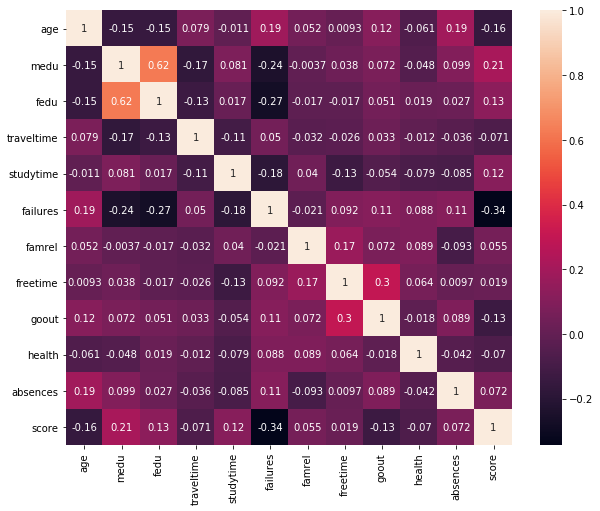

In [1621]:
# heatmap for all numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[cols_num].corr(), annot=True)
plt.show()

In [1622]:
# remove 'health' - no correlation with others
if 'health' in df:
    df.drop('health', axis=1, inplace=True)
    cols_num = cols_num.drop('health')

In [1623]:
# correlation between 'score' & others
df.corr()['score'].sort_values(ascending=False)

score         1.000000
medu          0.213349
higher        0.187024
fedu          0.130923
studytime     0.115741
paid          0.107403
absences      0.071603
internet      0.064526
famrel        0.055305
nursery       0.052859
freetime      0.019026
activities    0.010825
famsup       -0.007540
traveltime   -0.070559
schoolsup    -0.088650
romantic     -0.125829
goout        -0.129685
age          -0.155164
failures     -0.344338
Name: score, dtype: float64

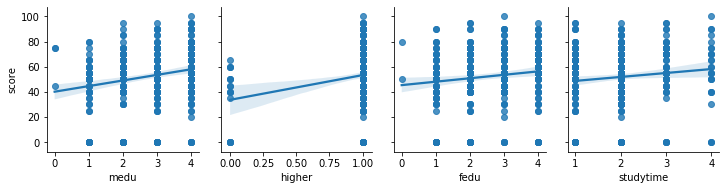

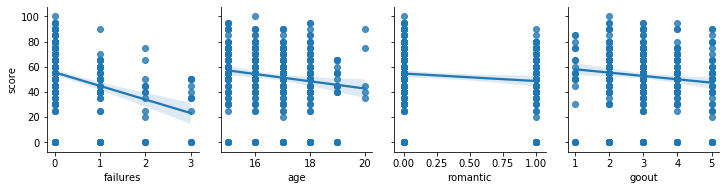

In [1624]:
get_pairplot(['medu', 'higher', 'fedu', 'studytime'])
get_pairplot(['failures', 'age', 'romantic', 'goout'])

##### 3.2. Categorical Variables

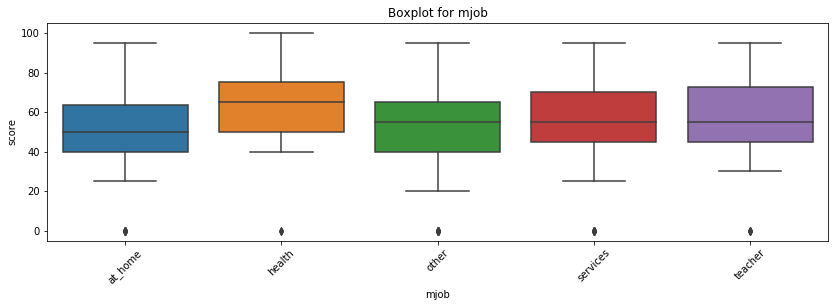

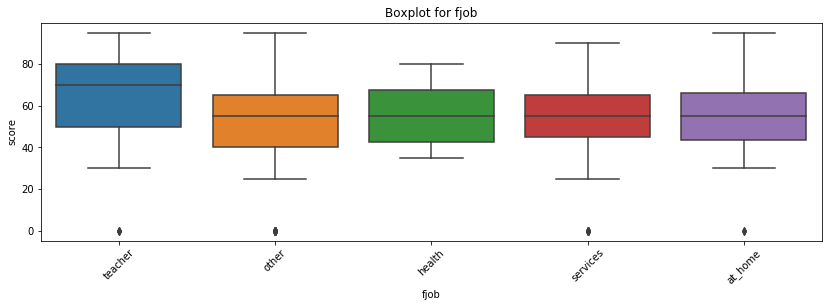

In [1625]:
for col in df[['mjob', 'fjob']].columns:
    get_boxplot(col)

In [1626]:
# student test. Columns affect the 'score'
for col in cols_cat:  # also columns with yes/no
    get_stat_dif(col)

significant differences:  address
significant differences:  mjob
significant differences:  paid
significant differences:  higher
significant differences:  romantic


###### 4. analyze columns
<pre>
'age', 'address', 
'medu', 'mjob', 'fedu', 
'studytime', 'goout'
'higher', 'romantic', paid
'failures', 
</pre>

In [1627]:
# age +
group_with_score('age').sort_index()

,mean,median,count
age,,,
15,56.280488,55.0,82
16,55.194175,55.0,103
17,51.377551,55.0,98
18,48.312500,50.0,80
19,40.238095,45.0,21
20,57.000000,45.0,5


С возрастом результаты немного снижаются.
Студентов старше 19 слишком мало для оценки, 


In [1628]:
# address +
group_with_score('address')

,mean,median,count
address,,,
R,46.927711,50.0,83
U,53.613861,55.0,303


Жизнь в городе немного влияет на результаты в положительную сторону. 
Но и живут в городе в 3 раза больше студентов.

In [1629]:
# medu +
group_with_score('medu')

,mean,median,count
medu,,,
1.0,43.125000,50.0,56
2.0,49.600000,55.0,100
3.0,51.822917,55.0,96
4.0,58.816794,60.0,131
0.0,65.000000,75.0,3


Образование матери влияет на результаты студентов.
Трёх человек, чьи матери не учились в школе, учитывать нет смысла.

In [1630]:
# mjob +
group_with_score('mjob')

,mean,median,count
mjob,,,
at_home,45.689655,50.0,58
other,49.527559,55.0,127
services,54.744898,55.0,98
teacher,55.181818,55.0,55
health,60.625000,65.0,32


Работа матери влияет на результаты.

In [1631]:
# fedu +
group_with_score('fedu')

,mean,median,count
fedu,,,
1.0,46.333333,50.0,75
3.0,54.042553,52.5,94
2.0,51.761905,55.0,105
4.0,55.730337,60.0,89
0.0,65.000000,65.0,2


Образование отца оказывает влияние на результаты. Двух студентов, чьи отцы не учились можно не учитывать.

In [1632]:
# studytime +
group_with_score('studytime')

,mean,median,count
studytime,,,
1.0,49.466019,50.0,103
2.0,50.820106,55.0,189
3.0,57.777778,60.0,63
4.0,56.296296,60.0,27


Время на учёбу помимоо школы повышает результаты. После 10 часов результаты перестают расти.

In [1633]:
# goout +-
group_with_score('goout')

,mean,median,count
goout,,,
4.0,49.506173,50.0,81
5.0,44.509804,50.0,51
1.0,49.347826,55.0,23
3.0,55.158730,55.0,126
2.0,55.990099,60.0,101


In [1634]:
print("Много времени с друзьями", df[df.goout >= 4].score.median())
print("Остальные: ", df[df.goout <= 3].score.median())

Много времени с друзьями 50.0
Остальные:  55.0


In [1635]:
# higher +-
group_with_score('higher')

,mean,median,count
higher,,,
0.0,33.684211,40.0,19
1.0,53.337989,55.0,358


С одной стороны, желание получить высшее образование влияет на результаты в положительную сторону, но с другой стороны - лишь 5% не имеют такого желания.

In [1636]:
# romantic +-
group_with_score('romantic')

,mean,median,count
romantic,,,
0.0,54.574468,55.0,235
1.0,48.617021,55.0,141


Возможно, романтические отношения незначительно влияют на отдельных студентов, но в целом тенденция слабая. В среднем студенты учатся так же.

In [1637]:
# paid +-
group_with_score('paid')

,mean,median,count
paid,,,
0.0,50.0,55.0,208
1.0,55.0,55.0,153


Возможно есть небольшое влияние на отдельных студентов.

In [1638]:
# failures +
group_with_score('failures')

,mean,median,count
failures,,,
3.0,29.642857,35.0,14
2.0,32.333333,40.0,15
1.0,40.000000,42.5,48
0.0,56.051724,55.0,290


Результаты студентов без неудач выше.

---

### Итоговые выводы.
 Более 10% пустых значений в колонках: 
'pstatus', 'paid'
 Выбросы найдены в столбцах: 
'fedu', 'famrel', 'age', 'absences', 
что позволяет сделать вывод о том, что данные достаточно чистые.

 Положительная корреляция параметров 
'score' и 'medu' может говорить о том, что результаты лучше у тех студентов, у чьих матерей образование выше.
Также, на результаты влияет высшее образования отца. 
 Заметно небольшое снижение результатов студентов с возрастом.
 Подавляющее число студентов не имеют неудач, и их результаты выше остальных. 
 
 Немношл лучше учатся студенты, живущие в городе.

 На результаты студентов оказывает влияние работа матери: выше результаты у тех, чьи матери работают в сфере здравоохранения, и ниже у тех, чьи матери не работают. 
 
 Платные занятия по математике влияют на результаты отдельных студентов.

 Результаты растут, если студенты уделяют до 10 часов помимо школы.

 Немного хуже учатся те, кто много времени проводит с друзьями.

 В целом влияние оказывает образование родителей (больше матери) и работа матери.

In [1641]:
df.loc[:, ['address', 'age', 'failures', 'fedu', 'goout',
           'medu', 'mjob', 'paid', 'studytime', 'score']].sample(3)

,address,age,failures,fedu,goout,medu,mjob,paid,studytime,score
93,U,16,0.0,2.0,3.0,4.0,teacher,1.0,2.0,50.0
392,R,20,3.0,1.0,3.0,1.0,other,0.0,1.0,35.0
325,U,18,0.0,4.0,3.0,4.0,other,0.0,3.0,55.0
